<a href="https://colab.research.google.com/github/UtG1209/Supply-Chain-Optimization/blob/main/Inventory_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# prompt: print the first 5 rows of the csv file in the files section

df_abc = pd.read_csv("/content/df_merged (1).csv")


In [3]:
df_abc.head()

,item_id,dept_id,cat_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,...,d_364,d_365,mean,std,sell_price,turnover,TO%,TO%_CS,ABC,CV
0,FOODS_3_586,FOODS_3,FOODS,516,479,328,376,319,430,405,...,462,538,535.254795,123.041574,1.595922,311792.086525,1.918966,1.918966,NaN,0.792068
1,FOODS_3_587,FOODS_3,FOODS,298,353,234,310,205,214,190,...,168,265,280.917808,74.761664,2.515532,257930.064894,1.587465,3.506430,A,0.589737
2,FOODS_3_202,FOODS_3,FOODS,106,113,65,80,75,90,98,...,133,184,154.575342,65.376786,4.260904,240400.218085,1.479575,4.986005,A,0.518238
3,FOODS_3_555,FOODS_3,FOODS,321,315,214,204,159,265,240,...,263,334,319.005479,78.299720,1.595887,185820.239291,1.143655,6.129661,A,NaN
4,FOODS_3_090,FOODS_3,FOODS,1046,1036,673,642,531,877,1117,...,1006,993,358.498630,501.098078,1.364521,178550.338085,1.098912,7.228572,A,0.840491


In [4]:
#Calculate Safety Stock and Reorder Point
ordering_cost_per_order = 50  # Example ordering cost per order
holding_cost_per_unit_per_year = 2  # Example holding cost per unit per year
lead_time_days = 5  # Example lead time in days
service_level_target = 0.95  # Example service level target


In [5]:
# Define demand variability thresholds
high_variability_threshold = 0.2 # Coefficient of Variation (CV) threshold

# Function to classify demand variability
def classify_demand_variability(row):
    if row['CV'] > high_variability_threshold or row['CV'] == np.NAN:
        return 'High Variability'
    else:
        return 'Low Variability'

df_abc['Demand_Variability'] = df_abc.apply(classify_demand_variability, axis=1)

# Define safety stock and reorder points
def calculate_safety_stock(row):
    if row['ABC'] == 'A' and row['Demand_Variability'] == 'High Variability':
        return row['mean'] * 2  # High safety stock
    elif row['ABC'] == 'A' or row['Demand_Variability'] == 'High Variability':
        return row['mean'] * 1.5  # Moderate safety stock
    else:
        return row['mean']  # Low safety stock

df_abc['Safety_Stock'] = df_abc.apply(calculate_safety_stock, axis=1)
df_abc['Reorder_Point'] = df_abc['mean'] * lead_time_days + df_abc['Safety_Stock']  # Assuming lead time of 5 days

print(df_abc[['item_id', 'ABC','CV', 'Demand_Variability', 'Safety_Stock', 'Reorder_Point']])


         item_id  ABC        CV Demand_Variability  Safety_Stock  \
0    FOODS_3_586  NaN  0.792068   High Variability    802.882192   
1    FOODS_3_587    A  0.589737   High Variability    561.835616   
2    FOODS_3_202    A  0.518238   High Variability    309.150685   
3    FOODS_3_555    A       NaN    Low Variability    478.508219   
4    FOODS_3_090    A  0.840491   High Variability    716.997260   
..           ...  ...       ...                ...           ...   
907  FOODS_1_147    C  0.919869   High Variability      0.004110   
908  FOODS_3_321    C       NaN    Low Variability      0.008219   
909  FOODS_3_181    C       NaN    Low Variability      0.002740   
910  FOODS_3_041    C  0.517101   High Variability      0.004110   
911  FOODS_3_064    C       NaN    Low Variability      0.002740   

     Reorder_Point  
0      3479.156164  
1      1966.424658  
2      1082.027397  
3      2073.535616  
4      2509.490411  
..             ...  
907       0.017808  
908       0.049

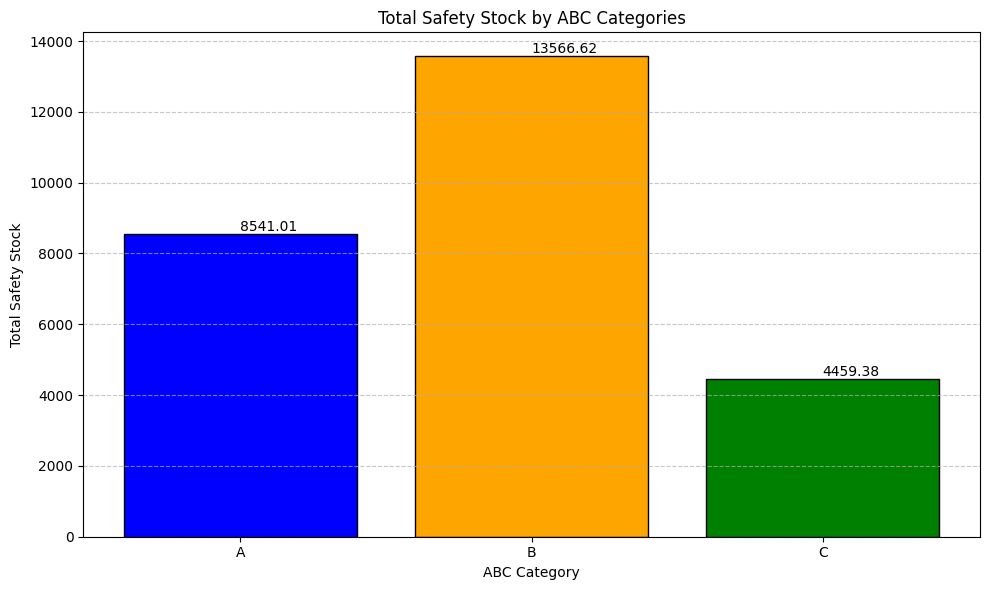

In [6]:
# Aggregate safety stock by ABC category
df_abc_agg = df_abc.groupby('ABC')['Safety_Stock'].sum().reset_index()

# Plot aggregated safety stock
plt.figure(figsize=(10, 6))
bars = plt.bar(df_abc_agg['ABC'], df_abc_agg['Safety_Stock'], color=['blue', 'orange', 'green'], edgecolor='black')
plt.title('Total Safety Stock by ABC Categories')
plt.xlabel('ABC Category')
plt.ylabel('Total Safety Stock')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

plt.tight_layout()
plt.show()


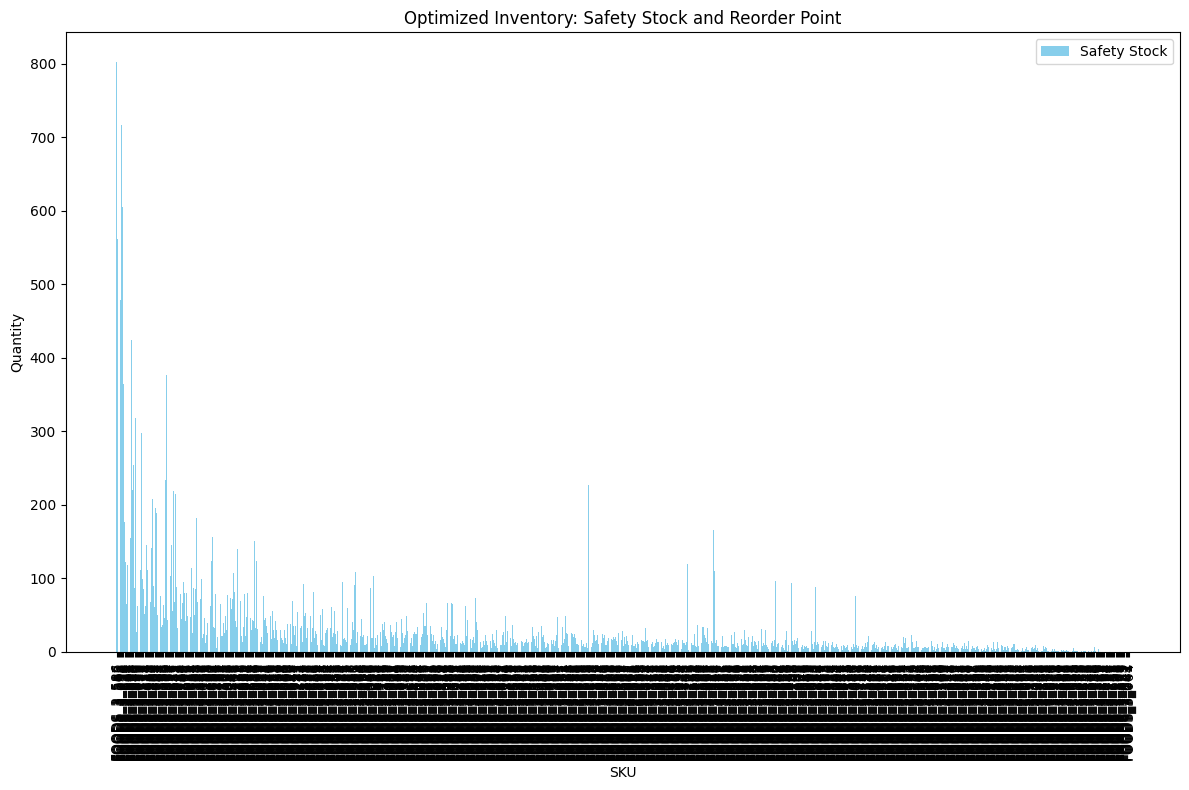

In [7]:
#Calculate Economic Order Quantity (EOQ)
df_abc['EOQ'] = np.sqrt((2 * df_abc['mean'] * ordering_cost_per_order) / holding_cost_per_unit_per_year)

#Visualize Results (Optional)
plt.figure(figsize=(12, 8))
plt.bar(df_abc['item_id'], df_abc['Safety_Stock'], color='skyblue', label='Safety Stock')
plt.xlabel('SKU')
plt.ylabel('Quantity')
plt.title('Optimized Inventory: Safety Stock and Reorder Point')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#Output Optimized Inventory Data
df_optimized_inventory = df_abc[['item_id', 'ABC', 'mean', 'std', 'CV', 'turnover', 'TO%', 'Safety_Stock', 'Reorder_Point', 'EOQ']]

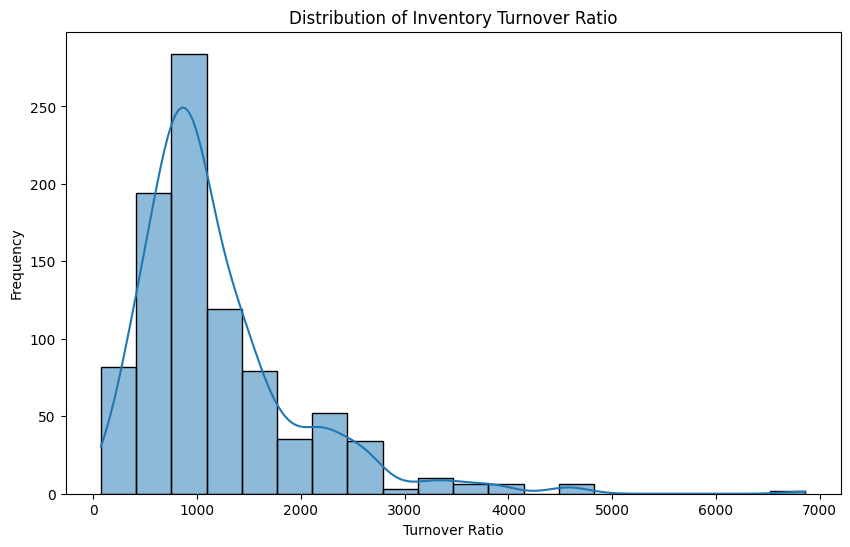

In [10]:
df_abc['Inventory_Turnover_Ratio'] = df_abc['turnover'] / df_abc['mean']

# Visualize Inventory Turnover Ratio
plt.figure(figsize=(10, 6))
sns.histplot(df_abc['Inventory_Turnover_Ratio'], bins=20, kde=True)
plt.title('Distribution of Inventory Turnover Ratio')
plt.xlabel('Turnover Ratio')
plt.ylabel('Frequency')
plt.show()

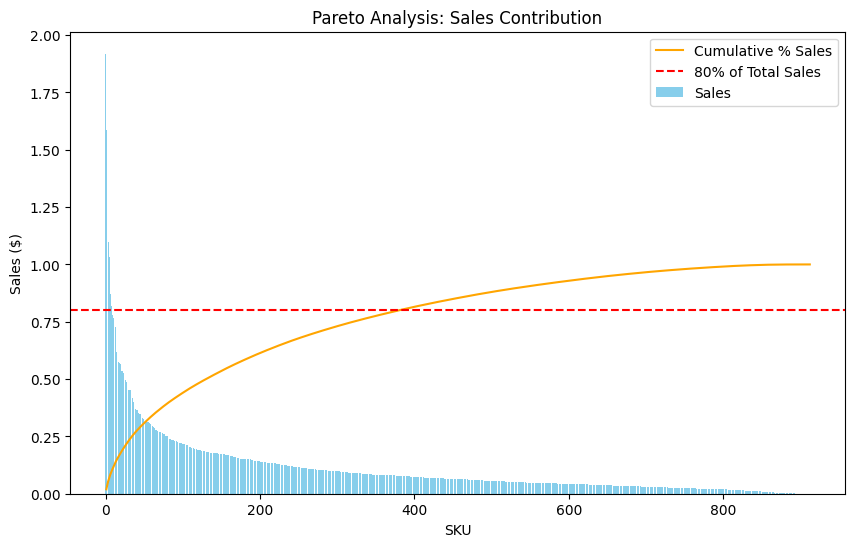

In [18]:
# Example Pareto Analysis: Top 20% of SKUs contributing to 80% of sales
total_sales = df_abc['turnover'].sum()
df_abc['TO%_CS'] = df_abc['turnover'].cumsum() / total_sales

plt.figure(figsize=(10, 6))
plt.bar(df_abc.index, df_abc['TO%'], color='skyblue', label='Sales')
plt.plot(df_abc.index+1 , df_abc['TO%_CS'], color='orange', label='Cumulative % Sales')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% of Total Sales')
plt.title('Pareto Analysis: Sales Contribution')
plt.xlabel('SKU')
plt.ylabel('Sales ($)')
plt.legend()
plt.show()


In [ ]:
import plotly.express as px

# Example Interactive Dashboard: Sales Performance by SKU
fig = px.scatter(df_abc, x='mean', y='turnover', color='ABC', hover_data=['item_id'])
fig.update_layout(title='Sales Performance by SKU',xaxis_title='Mean Demand',yaxis_title='Total Sales ($)')
fig.show()
